DFM / online-coupled bloom tracer Run
--

This version matches with run_dfm_bloom_tracers_v02 / bloom_tracers_v03.

Initially with just 1 swimming speed (10 m/d) with uniform distribution (for growth potential),
temperature, and initialization of temperature from 8/2 temperature imagery.

Later includes 5 m/d and 10 m/d, with (v07) and without (v06) temperature

In [88]:
import matplotlib.pyplot as plt
%matplotlib widget

In [106]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, xr_utils, memoize
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb
from stompy.grid import unstructured_grid
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils, field
from stompy.io.local import noaa_coops
from matplotlib import gridspec
import pdb

import os
import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import Video
import time
import six
import datetime

In [107]:
# These online-coupled dfm-dwaq runs.

# Main run
#run_dir="bloom_tracers_v03/run_20220802T1200_20220830T0000_v00"
# Updated forcing for ocean BC, air temp, fix longitude for solar rad.
# run_dir="bloom_tracers_v04/run_20220802T1200_20220830T0000_v02"
# swim_speeds=[10]
# Switch to just 5 m/d, update temperature parameters:
# Use CdWind for Stanton and Dalton numbers
#run_dir="bloom_tracers_v05/run_20220802T1200_20220830T0000_v00"
#swim_speeds=[5]

# No temperature run.
#run_dir="bloom_tracers_v06/run_20220802T1200_20220830T0000_v00"
#swim_speeds=[5,10]

# Temperature run with initial condition based on ACSPO daily sub-skin
# data, and shift time of temperature initialization to increase alignment
# with daily data.
run_dir="bloom_tracers_v08/run_20220802T1930_20220830T0000_v00"

model=dfm.DFlowModel.load(run_dir)

In [108]:
ds=model.map_dataset()

In [109]:
# Load multiple runs for comparisons
# Updated forcing for ocean BC, air temp, fix longitude for solar rad.
#model_v04 = dfm.DFlowModel.load("bloom_tracers_v04/run_20220802T1200_20220830T0000_v02")
#ds_v04 = model_v04.map_dataset(chain=False)

In [110]:
dss=[ds]

In [111]:
grid=ds.grid
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


Temperature 
--

In [97]:
avhrr_ds=xr.open_dataset("RS_temperature/extrapolated_avhrr.nc")

In [281]:
# Compare AVHRR and DFM surface and bed.
if 0: # animation
    fig,axs=plt.subplots(1,2, figsize=(9.5,4.5))
    
    frame_dir=os.path.join(run_dir,'temp_frames')
    if not os.path.exists(frame_dir):
        os.makedirs(frame_dir)
    
    cbar=None
    for model_tidx in range(ds.dims['time']):
        for ax in axs:
            ax.cla()
            ax.set_adjustable('datalim')
            ax.axis('off')
            ax.axis('equal')
    
        cmap=scmap.load_gradient('hot_desaturated.cpt')
        
        ax=axs[0] 
        scal=ds['tem1'].isel(time=model_tidx,laydim=0).values
        model_t = ds.time.isel(time=model_tidx).values
        coll=grid.tripcolor_cell_values(scal,cmap=cmap,ax=ax)
        ax.text(0.04,0.98,str(ds.time.isel(time=model_tidx).values)[:16], transform=ax.transAxes)
        
        ax=axs[1] 
        scene=avhrr_ds.sel(time=model_t,method='nearest')
        coll2=plot_utils.pad_pcolormesh(scene.x, scene.y, scene.sst.values, cmap=cmap,ax=ax)
        ax.text(0.04,0.98,str(scene.time.values)[:16], transform=ax.transAxes)
        plot_wkb.plot_wkb(grid_poly,fc='none',ec='k',lw=0.5,zorder=3)
        
        axs[1].axis(axs[0].axis())
        
        plt.setp([coll,coll2],clim=[9,26])
        
        fig.subplots_adjust(top=0.98,left=0.02, right=0.98, bottom=0.05)
    
        if cbar is None:
            cbar=plt.colorbar(coll, ax=axs, orientation='horizontal', label='Temp °C', fraction=0.06, pad=0.05,
                             shrink=0.5) 
    
        fig.savefig(os.path.join(frame_dir,f'temp_{model_tidx:04d}.png'))

In [10]:
if 0:
    from stompy.plot import mkanim
    mkanim.mkanim(os.path.join(frame_dir,"temp.mp4"),
                  os.path.join(frame_dir,"temp_%04d.png"),
                  fps=8)

In [112]:
# Gather temperature observations
import insitu_temperature

insitu_df = insitu_temperature.all_stations()

In [100]:
stn_df = insitu_df.groupby('station').first()
stn_df

array(['Alameda', 'Alcatraz', 'DMB', 'Fort Point', 'HAY', 'Martinez',
       'Pier17', 'Point Reyes', 'Redwood', 'Richmond', 'Richmond Br USGS',
       'SHL', 'SLM', 'SM', 'SMB_USGS'], dtype=object)

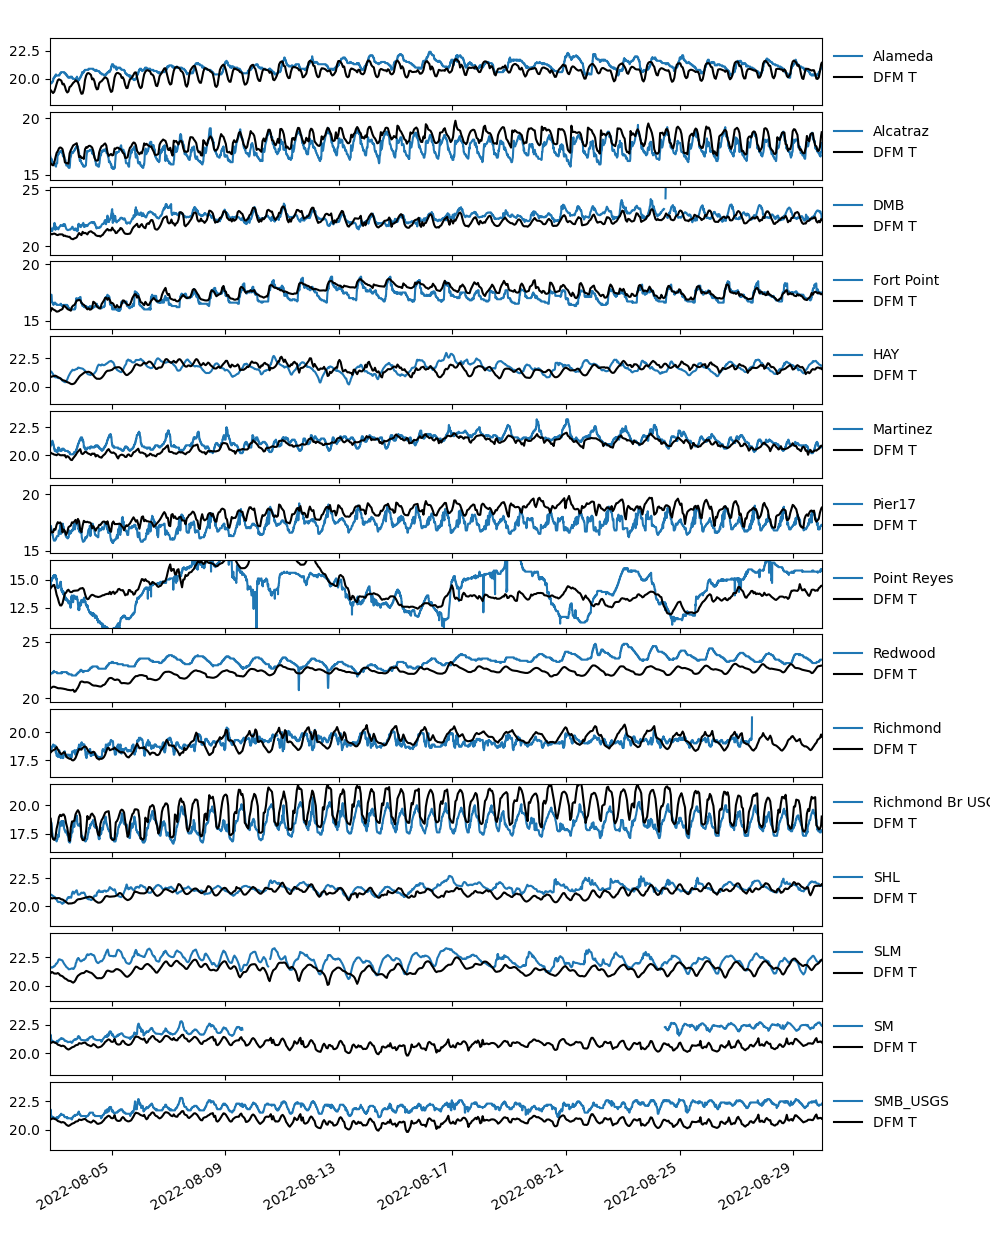

In [120]:
# Representative points
# manual picks from plot
#l2m=proj_utils.mapper('WGS84','EPSG:26910')
#sites=dict( Alcatraz = np.r_[550030,4.18629e6],
#            Alameda = np.r_[562410, 4.17998e6],
#            SMB = np.r_[566900, 4.16085e6], 
#            Pier17 = np.r_[553056, 4184134],
#            SHL = l2m( [-122.243,37.63079] ),
#            SLM = l2m( [-122.218,37.6742]),
#            HAY = l2m( [-122.201,37.61174]))

stn_df = insitu_df.groupby('station').first()

fig,axs=plt.subplots(len(stn_df),1,sharex=True,figsize=(9.9,12.5))

#dss=[ds_v04,ds]
#ds_labels=['v04\nImproved forcing','v05\nStanton/Dalton']
dss=[ds]
ds_labels=['v08']
ds_colors=['k','g']

fixed_range=6.0
show_avhrr=False

for ax,site in zip(axs,stn_df.index.values):
    xy=np.r_[ stn_df.loc[site,'x'], stn_df.loc[site,'y'] ]
    stn_sel = insitu_df[ insitu_df.station==site ]
    ax.plot(stn_sel.time, stn_sel.T_degC,label=site)
                
    c=grid.select_cells_nearest(xy)
    if len(dss)==1:
        model_temp=ds['tem1'].isel(nFlowElem=c, laydim=-1)
        ax.plot(ds.time.values, model_temp.values,color='k',label=f"DFM T")
    else:
        for d,label,color in zip(dss,ds_labels,ds_colors):
            ax.plot(d.time.values, d['tem1'].isel(nFlowElem=c,laydim=-1),color=color,label=label)
            
    if 0: # air temp from model
        air_temp=ds['Tair'].isel(nFlowElem=c)
        ax.plot(ds.time.values, air_temp,color='tab:blue',label="DFM T$_{air}$")

    #ax.plot(noaa.time, noaa.air_temperature, color='tab:green', label=noaa_label + " T$_{air}$")

    if show_avhrr: # Show RS extrap
        dists = (xy[0] - avhrr_ds.x.values)**2 + (xy[1] - avhrr_ds.y.values)**2
        dists[~avhrr_ds.water.values] = 1e8 # ignore land
        row,col=np.unravel_index( np.argmin(dists), dists.shape)
        err = utils.dist(xy - np.r_[avhrr_ds.x.values[row,col], avhrr_ds.y.values[row,col]])
        print(f"Site: {site}  station-pixel distance: {err:.1f} m")
        avhrr_t=avhrr_ds.extrap_spatiotemporal_mu.isel(latitude=row,longitude=col)
        if 0:
            ax.plot(avhrr_ds.time.values, avhrr_t, label=f"Extrap RS", color='tab:purple')
        else:
            avhrr_var=avhrr_ds.extrap_spatiotemporal_var.isel(latitude=row,longitude=col)
            t_low = avhrr_t - np.sqrt(avhrr_var)
            t_high = avhrr_t + np.sqrt(avhrr_var)
            ax.fill_between(avhrr_ds.time.values, t_low, t_high, label=f"Extrap RS", color='tab:purple',
                           alpha=0.2, zorder=-1)
            
    ax.legend(loc='upper left', bbox_to_anchor=(1,1),frameon=0)
    ax.axis(xmin=ds.time.values[0], xmax=ds.time.values[-1]) # ymin=12,ymax=26)
    if fixed_range:
        Tmedian = np.nanmedian(stn_sel.T_degC)
        if len(dss)==1:
            Tmedian = 0.5*(Tmedian + np.nanmedian(model_temp.values))
        ax.axis(ymin=Tmedian-fixed_range/2.0,ymax=Tmedian+fixed_range/2.0)
        
fig.autofmt_xdate()
fig.subplots_adjust(left=0.05,right=0.83,top=0.97,bottom=0.08,hspace=0.1)



In [29]:
# What does DFM think is going with the other heat flux terms?
if 0:
    to_pdt = np.timedelta64(-7,'h')
    
    fig,axs=plt.subplots(3,1,sharex=True,figsize=(9.9,7.5))
    
    ax,axQ,axH = axs
    #site='Alcatraz'
    site='SMB'
    
    noaa=None
    xy=sites[site]
        
    c=grid.select_cells_nearest(xy)
    model_temp=ds['tem1'].isel(nFlowElem=c, laydim=-1)
    ax.plot(ds.time.values + to_pdt, model_temp.values,color='k',label=f"DFM T")
    
    if 1: # air temp from model
        air_temp=ds['Tair'].isel(nFlowElem=c)
        ax.plot(ds.time.values + to_pdt, air_temp,color='tab:blue',label="DFM T$_{air}$")
    
    if site=='Alcatraz':
        noaa = noaa_sf
           
        ax.plot(noaa.time+to_pdt, noaa.water_temperature, color='tab:red', label="NOAA T")
        #ax.plot(noaa.time+offset + to_pdt, noaa.air_temperature, color='tab:green', label="NOAA T$_{air}$"+offset_str)
        ax.plot(alcatraz_usgs.time+to_pdt, alcatraz_usgs.temperature_water, color='orange',label='Alcatraz T (USGS)')
    
    ax.legend(title=site,loc='upper left', bbox_to_anchor=(1,1),frameon=0)
    
    for f in ['Qsun','Qlong','Qeva','Qcon','Qfreva','Qfrcon','Qtot']:
        Q = ds[f].isel(nFlowElem=c) 
        axQ.plot(ds.time.values + to_pdt, Q.values, label=f)
        print(f"Mean {f}: {Q.values.mean()}")
        
    if 1: # tides
        wse=ds['s1'].isel(nFlowElem=c)
        axH.plot(ds.time + to_pdt, wse, label='DFM Stage')
        if noaa is not None:
            axH.plot(noaa.time + to_pdt, noaa.water_level, label=f'NOAA stage\n({noaa.name.item()})')
    
    #ax.axis(xmin=ds.time.values[0], xmax=ds.time.values[-1],ymin=12,ymax=30)
    ax.axis( (19206.879, 19213.122, 13.52, 19.7878) )
    axQ.legend(title='Heat Fluxes',loc='upper left', bbox_to_anchor=(1,1),frameon=0)
    axH.legend(loc='upper left',bbox_to_anchor=(1,1),frameon=0)
    for ax in axs:
        ax.grid(axis='x')
            
    fig.autofmt_xdate()
    axs[-1].set_xlabel('PDT')
    
    fig.subplots_adjust(left=0.05,right=0.84,top=0.97,bottom=0.12)

In [30]:
if 0:
    # Velocity and strat on ocean boundary
    fig,ax=plt.subplots()
    
    tidx=20
    t_pdt=str(ds.time.values[tidx] - np.timedelta64(7,'h'))[:16]
    #scal = ds['tem1'].isel(time=tidx,laydim=-1)
    #scal = ds['clou'].isel(time=tidx)
    scal = ds['ucy'].isel(time=tidx,laydim=0) 
    
    coll=grid.tripcolor_cell_values( scal.values, cmap=scmap.load_gradient('hot_desaturated.cpt') )
    ax.text(0.05,0.9,t_pdt+ ' PDT',
            transform=ax.transAxes)
    ax.axis('equal')
    plt.colorbar(coll,label="T",shrink=0.8,fraction=0.10)
    ax.axis('off')
    fig.subplots_adjust(left=0.05, right=0.96,bottom=0.05,top=0.98)

Air Temperature Forcing
--

In [31]:
if 0:
    # hac_fn = os.path.join(run_dir,"bc_files/hac_linear_wind_2022_bloom.tem")
    # grd_fn=os.path.join(run_dir,"meteo_coarse.grd")
    
    # this is 'meta_on_curvilinear_grid' 
    # unstructured_grid.UnstructuredGrid.read_delft_curvilinear(grd_fn)
    
    fig,ax=plt.subplots()
    
    tidx=0
    t_pdt=str(ds.time.values[tidx] - np.timedelta64(7,'h'))[:16]
    
    coll=grid.tripcolor_cell_values( ds['Tair'].isel(time=tidx).values, cmap=scmap.load_gradient('hot_desaturated.cpt') )
    ax.text(0.05,0.9,t_pdt+ ' PDT',
            transform=ax.transAxes)
    ax.axis('equal')
    plt.colorbar(coll,label="T$_{air}$",shrink=0.8,fraction=0.10)
    ax.axis('off')
    fig.subplots_adjust(left=0.05, right=0.96,bottom=0.05,top=0.98)

Checking swim results
--

Looks like setting swimming via DFM is working, and the age/depth/radiation tracers
give reasonable results.

In [28]:
groups=[0] # ,1,2]


In [32]:
if 0:
    # Check to see whether upward swimming is working, and if age/property tracers are working.
    point=[557240,4185530] # SE of Treasure Island.
    c=ds.grid.select_cells_nearest(point)
    
    fig,axs=plt.subplots(2,1,sharex=True,sharey=False, squeeze=False,figsize=(9.5,4),
                        height_ratios=[0.8,0.2])
    axs=axs[:,0]
    
    z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)
    
    colls=[]
    ax=axs[0]
    g=0
    conc = ds[f'conc{g}'].isel(nFlowElem=c)
    X,Z,S = xr.broadcast(conc.time, z, conc)
    Snorm = S/S.mean(dim='laydim')
    colls.append( plot_utils.pad_pcolormesh( X + to_pdt, Z, Snorm, cmap='turbo', ax=ax) )
    
    if 1: 
        axs[1].fill_between(ds.time+to_pdt, 0, ds.Qsun.isel(nFlowElem=c), fc='yellow',label='Qsun', ec='k',lw=0.8)
        plt.setp(axs[1].get_yticklabels(), visible=0)
        axs[1].set_ylabel('Qsun')
        axs[1].axis(ymin=0)
    
    plt.setp(colls[:-1], clim=colls[-1].get_clim()) 
    fig.subplots_adjust(left=0.05,right=0.97,bottom=0.10,top=0.96)
    plt.colorbar( colls[0], ax=axs, label="Conc",fraction=0.06)
    axs[0].axis((19206.814, 19214.735, -14.45, 3.551))
    axs[-1].set_xlabel('PDT')

In [45]:
def ratio(a,b,eps):
    return a / b.clip(eps)

In [33]:
# Similar, but check on rad
if 0:
    fig,axs=plt.subplots(len(groups),1,sharex=True,sharey=True,squeeze=False)
    axs=axs[:,0]
    
    colls=[]
    for ax,g in zip(axs,groups):
        radc = ds[f'radc{g}'].isel(nFlowElem=c)
        conc = ds[f'conc{g}'].isel(nFlowElem=c)
        age=(ds.time - ds.time.values[0])/np.timedelta64(1,'D')    
        rad=ratio(radc, conc*age, 1e-5)
    
        T,Z,S = xr.broadcast(ds.time, z, rad)
        colls.append( 
            plot_utils.pad_pcolormesh( T, Z, S, cmap='turbo', ax=ax) 
        )
        
    plt.setp(colls, clim=[0,20])
    plt.colorbar( colls[0], ax=axs, label="rad")

Plotting All Fields
--

In [34]:
if 0:
    tidx=50
    
    plots=[
        dict(label='Conc', clim=[0.0,2.0], data_fn=lambda snap,g: snap[f'conc{g}']),
        #dict(label='$log_{10}$ Conc', clim=[-4,0], data_fn=lambda snap,g: np.log10(snap[f'conc{g}'].values.clip(1e-4))),
        dict(label='Average rad', clim=[10,30],data_fn=lambda snap,g: ratio( snap[f'radc{g}'].values, age*snap[f'conc{g}'].values, 1e-5)),
        #dict(label="Depth exposure (m)", clim=[0,10], data_fn=lambda snap,g: ratio(snap[f'depc{g}'].values, snap[f'agec{g}'].values,1e-5)),    
        #dict(label="Age (d)", clim=[0,15], data_fn=lambda snap,g: ratio(snap[f'agec{g}'].values, snap[f'conc{g}'].values,1e-5)),         
    ]
    
    snap2d=ds.isel(time=tidx,laydim=-1)
    age=(snap2d.time.values - ds.time.values[0])/np.timedelta64(1,'D')
    
    for plot in plots: 
        fig,axs=plt.subplots(1,len(groups),figsize=(8,4),squeeze=False)
        axs=axs[0,:]
        for g,ax in enumerate(axs):
            ax.set_adjustable('datalim')
            fig.subplots_adjust(left=0.01, right=0.94, top=0.98, bottom=0.02)
            ax.xaxis.set_visible(0)
            ax.yaxis.set_visible(0)    
            kw=dict(lw=0.5,edgecolor='face', cmap='turbo')    
            scal=plot['data_fn'](snap2d,g) 
                    
            ccoll=ds.grid.plot_cells( values=scal, clim=plot['clim'], ax=ax, **kw)
            plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
            plt.colorbar(ccoll,label=plot['label'],ax=ax)
            ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
            ax.text(0.57,0.9, utils.strftime(snap2d.time.values), transform=ax.transAxes)

In [35]:
from stompy import memoize

@memoize.memoize(lru=1)
def extract_tracers(tidx,layer,Isat=30.0,thresh=1e-5,group=0):
    """
    layer: mean, surface, integrated, or a laydim index 0=bed, 15=surface
    layer=mean is not necessarily what you want! That averages light exposure
    over the layers.
    layer=integrated will keep the layers intact. Not implemented.
    """
    # Extraction
    # instantaneous release, so age is a given.
    t=ds.time.isel(time=tidx).values
    age_d = (t - ds.time.values[0]) / np.timedelta64(86400,'s')

    assert layer!='integrated',"Not implemented"
    if layer in ['mean']:
        snap=ds.isel(time=tidx)
        conc = snap[f'conc{group}'].values.mean(axis=1).clip(0,np.inf)
    else:
        snap=ds.isel(time=tidx,laydim=layer)
        conc  = snap[f'conc{group}'].values

    # These should be about the same, not sure why one would be preferable over the
    # other.
    #Imean =  ratio( snap['radc0'].values, snap['agec0'].values, thresh)
    # 1.85 = 0.45 total->PAR correction, 4.57 W -> uEin/s conversion, 0.90 -> surface albedo correction.
    Imean = 1.85 * ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
            
    kLight = (Imean/(Imean + Isat))
    if layer=='mean':
        kLight = kLight.mean(axis=1) # happen to know that layer is the second dimension    

    Imean[np.isnan(Imean)]=0.0 
    kLight = fill(kLight, iterations=120)
    return dict(age_d=age_d, conc=conc, kLight=kLight, Imean=Imean, t=t, depth=snap['waterdepth'].values)  


In [84]:
# tide, insolation time series
@memoize.memoize()
def cimis():
    print("Reloading cimis")
    cimis_ds=xr.open_dataset('/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2022_bloom.nc')
    # Starts as PST, but the model is UTC.
    cimis_ds=cimis_ds.set_coords('time').swap_dims({'Date':'time'})
    cimis_ds['time']=cimis_ds['time']+np.timedelta64(8,'h')
    sol_rad=cimis_ds['HlySolRad'].values
    sol_rad=utils.fill_invalid(sol_rad)
    cimis_ds['sol_rad']=('time',),sol_rad
    sel = utils.select_increasing(cimis_ds.time.values)
    return 1.85*cimis_ds['sol_rad'].isel(time=sel)

c=ds.grid.select_cells_nearest([564400,4161700])
tides_da = ds['s1'].isel(nFlowElem=c)


def tide_panel(ax,t):
    t_off=np.timedelta64(7,'h') # PDT
    da_cimis = cimis()
    ax.fill_between(da_cimis.time-t_off,da_cimis, color='orange', lw=0.8) # fc='#eeee00', ec='#eeee00',lw=0.8) 
    ax_tides=ax.twinx()
    ax_tides.plot(tides_da.time-t_off, tides_da,lw=1.25)
    ax_tides.yaxis.set_visible(0)
    #ax.yaxis.set_visible(0)
    ax_tides.axis('off')
    ax.axis(ymin=0,ymax=2000,xmin=ds.time.values[0]-t_off,xmax=ds.time.values[-1]-t_off)
    ax.axvline(t-t_off,color='k',lw=1.25)
    plt.setp(ax.get_xticklabels(),visible=0)

#fig,ax=plt.subplots(figsize=(8,1.3))
#tide_panel(ax,ds.time.values[385])

Interpolated RS Temperature vs. In situ Stations
==

Growth Potential
==

In [100]:
# Largely based on the GP code in bloom-timing.ipynb

In [252]:
# hourly output.
# conc0, radc0. For growth potential I just want conc0 and instantaneous rad.
# should include CIMIS solar radiation, time/space variable Kd
# Even though the substance file requests these outputs, they do not exist in the map
# or history output, so reconstruct. 

import common
from common import k_indef

class GrowthPotentialMap:
    map_ds = ds
    # This is from some water column code in bloom_timing.ipynb
    Gmax = 1.0
    Isat = 25

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        self.centers=self.map_ds.grid.cells_centroid()

    @memoize.imemoize()
    def solar_rad_timeseries(self):
        return model.read_tim( os.path.join(model.run_dir,'RadSurf.tim'), columns=['RadSurf'] )
        
    def get_solar_radiation(self, tidx):
        # Could also get solar radiation from original CIMIS data
        sol_rad = self.solar_rad_timeseries()
        t=self.map_ds.time.values[tidx]
        return np.interp( t, sol_rad.time, sol_rad.RadSurf )

    @memoize.imemoize()
    def Kd_spacetime(self):
        return xr.open_dataset(os.path.join(model.run_dir,'seg-ExtVl.nc'))
        
    def get_Kd(self, tidx):
        extvl_ds = self.Kd_spacetime()
        t = self.map_ds.time.values[tidx]
        extvl_fld = field.SimpleGrid.from_curvilinear(extvl_ds.x.values,
                                                      extvl_ds.y.values,
                                                      extvl_ds.ExtVl.sel(time=t,method='nearest').values)
        return extvl_fld(self.centers)

    #@memoize.imemoize(lru=300)
    def growth_potential(self,tidx):
        """
        vertically integrated growth rate, weighted by concentration distribution.
        returns dataframe in order of grid cells
        """
        results = [] 
        snap=self.map_ds.isel(time=tidx)
        
        # grab these for all cells, layers, just this timestep.
        conc = snap['conc0'].values.clip(0.0)
        z_int = xr_utils.decode_sigma(snap, self.map_ds['LayCoord_w']).values

        sol_rad = self.get_solar_radiation(tidx).clip(1e-12,2000)
        Kd = self.get_Kd(tidx)

        if 0: # serial
            for c in utils.progress(range(self.map_ds.grid.Ncells())):
                # positive up, first interface is the bed, last interface is the surface.
                result = self.growth_potential_one(conc[c,:], sol_rad, Kd[c], z_int[c,:])
                result['cell'] = c
                result['tIdx'] = tidx
                results.append(result)
            self.results=pd.DataFrame(results)

        # Vectorize over the domain.
        if 1:
            depths=-z_int[:,:] + z_int[:,-1:] # [cell,interface]
            klight_indefs = common.k_indef(depths,Kd[:,None], sol_rad, self.Isat)
            Hs=depths[:,0]
            thresh=1e-10
            conc_avgs = (np.sum(conc[:,:]*np.diff(z_int[:,:],axis=1),axis=1) / Hs).clip(thresh)
            klight_defs = np.diff(-klight_indefs,axis=1)
            growth_ints = self.Gmax*np.sum(conc*klight_defs,axis=1) / conc_avgs
            growth_ints[ conc_avgs<=thresh ] = 0.0
            growth_avgs = growth_ints / Hs
            growth_mixeds = self.Gmax*np.sum(klight_defs,axis=1) / Hs
            growth_mixeds[ conc_avgs<=thresh ] = 0.0

            #if not np.allclose( growth_ints, self.results['growth_int'].values ):
            #    import pdb
            #    pdb.set_trace()
            self.results = pd.DataFrame()
            self.results['cell'] = np.arange(self.map_ds.grid.Ncells())
            self.results['tIdx'] = tidx
            self.results['growth_int'] = growth_ints
            self.results['growth_avg'] = growth_avgs
            self.results['growth_mixed'] = growth_mixeds
            
        self.results.attrs['time'] = self.map_ds.time.values[tidx]

        return self.results
    
    def growth_potential_one(self, conc, sol_rad, Kd, z_int):
        res = {}
            
        # z_int is positive up, and holds negative values, from -H to eta
        # But k_indef is expecting z to be positive down, starting from z=0 at the surface
        # This gets z_int as positive down, z=0 at the surface.
        # Still ordered bed->surface, though.
        depth=-z_int + z_int[-1]
        klight_indef = common.k_indef(depth,Kd,sol_rad,self.Isat)

        # separate effects of tidal mixing, phase of tides w.r.t. daylight
        #kfullsun_indef=k_indef(-self.z_int,self.Kd,1000,self.Isat)
        #sol_rad_ideal = utils.ideal_solar_rad(self.t)
        #kideal_indef  = k_indef(-self.z_int,self.Kd,sol_rad_ideal,self.Isat)
        #sol_rad_diurnal = utils.ideal_solar_rad(self.t, declination=False)
        #kdiurnal_indef  = k_indef(-self.z_int,self.Kd,sol_rad_diurnal,self.Isat)

        # Concentration weighted average
        # negate klight_indef because depth is descending.
        H=z_int[-1] - z_int[0]
        
        # This assumes the layers are evenly spaced.
        #conc_avg=conc.mean()
        # This accounts for stretching
        conc_avg = np.sum(conc*np.diff(z_int)) / H

        if conc_avg > 1e-10:
            klight_def = np.diff(-klight_indef)
            growth_int = res['growth_int'] = self.Gmax*np.sum(conc*klight_def) / conc_avg
            res['growth_avg'] = growth_int / H            
            res['growth_mixed']=self.Gmax*np.sum(klight_def) / H
        else:
            res['growth_avg'] = 0.0
            res['growth_int'] = 0.0
            res['growth_mixed'] = 0.0
                        
        return res

gs = GrowthPotentialMap()

df = gs.growth_potential(tidx=105) # 2022-08-06T21:00

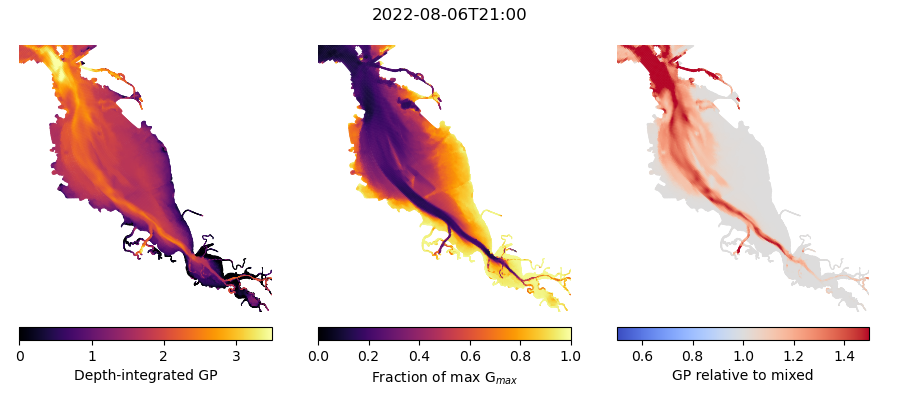

In [253]:
fig,axs = plt.subplots(1,3, figsize=(9,4.0))
for ax in axs:
    ax.axis('off')
    ax.set_adjustable('datalim')

def plot_cells(ax,v,label,**kw):
    coll = gs.map_ds.grid.plot_cells(values=v,ax=ax,**kw)
    coll.set_lw(0.5)
    coll.set_edgecolor('face')
    plt.colorbar(coll, orientation='horizontal',ax=ax, label=label, pad=0.05, fraction=0.1)
    
# Growth potential
plot_cells(axs[0],df['growth_int'],'Depth-integrated GP', cmap='inferno', clim=[0,3.5])
plot_cells(axs[1],df['growth_avg'],'Fraction of max G$_{max}$', cmap='inferno', clim=[0,1])

# Relative to no swimming
plot_cells(axs[2], df['growth_avg'] / df['growth_mixed'], cmap='coolwarm', clim=[0.5,1.5],
           label='GP relative to mixed')

fig.suptitle(str(df.attrs['time'])[:16])
fig.tight_layout()
for ax in axs:
    ax.axis((548258., 592431., 4146961., 4181391.))

In [254]:
# Calculate for all time steps
all_df=[]
for tidx in utils.progress(range(gs.map_ds.dims['time'])):
    df = gs.growth_potential(tidx=tidx)
    df['time'] = df.attrs['time']
    all_df.append(df)


INFO:utils:23/661
INFO:utils:43/661
INFO:utils:63/661
INFO:utils:81/661
INFO:utils:102/661
INFO:utils:124/661
INFO:utils:144/661
INFO:utils:162/661
INFO:utils:181/661
INFO:utils:201/661
INFO:utils:222/661
INFO:utils:244/661
INFO:utils:265/661
INFO:utils:288/661
INFO:utils:311/661
INFO:utils:324/661
INFO:utils:344/661
INFO:utils:362/661
INFO:utils:382/661
INFO:utils:401/661
INFO:utils:421/661
INFO:utils:442/661
INFO:utils:461/661
INFO:utils:482/661
INFO:utils:501/661
INFO:utils:523/661
INFO:utils:545/661
INFO:utils:562/661
INFO:utils:583/661
INFO:utils:604/661
INFO:utils:624/661
INFO:utils:644/661


In [255]:
# Stuff into netcdf, then come back and tidal average
df_comb = pd.concat(all_df)

In [256]:
df2=df_comb.set_index(['time','cell'])
df2.head()

tIdx    growth_int    growth_avg  growth_mixed
time                cell                                                
2022-08-02 12:00:00 0        0  7.993606e-15  8.522576e-15  8.522576e-15
                    1        0  4.440892e-16  6.675107e-14  6.675107e-14
                    2        0 -8.881784e-16 -1.258594e-13 -1.258594e-13
                    3        0  7.993606e-15  4.418436e-15  4.418436e-15
                    4        0  7.993606e-15  6.526309e-15  6.526309e-15

In [257]:
ds_results = xr.Dataset.from_dataframe(df2)
del ds_results['tIdx']
gs.map_ds.grid.write_xarray(ds_results)
ds_results

<xarray.Dataset>
Dimensions:       (time: 661, cell: 49996, node: 44184, face: 49996,
                   maxnode_per_face: 6, edge: 94194, node_per_edge: 2)
Coordinates:
  * time          (time) datetime64[ns] 2022-08-02T12:00:00 ... 2022-08-30
  * cell          (cell) int64 0 1 2 3 4 5 ... 49991 49992 49993 49994 49995
Dimensions without coordinates: node, face, maxnode_per_face, edge,
                                node_per_edge
Data variables:
    growth_int    (time, cell) float64 7.994e-15 4.441e-16 ... 8.221 8.129
    growth_avg    (time, cell) float64 8.523e-15 6.675e-14 ... 0.5483 0.5452
    growth_mixed  (time, cell) float64 8.523e-15 6.675e-14 ... 0.1303 0.1308
    mesh          int64 1
    node_x        (node) float64 5.809e+05 5.825e+05 ... 5.425e+05 5.426e+05
    node_y        (node) float64 4.151e+06 4.152e+06 ... 4.153e+06 4.153e+06
    face_node     (face, maxnode_per_face) int32 0 555 329 -1 ... 44132 -1 -1
    edge_node     (edge, node_per_edge) int32 0 555 555 ... 44183 44183 44132

In [258]:
ds_results.to_netcdf(os.path.join(model.run_dir,"growth_potential_v00.nc"))

In [259]:
# 24-h average
# Model time is UTC. I want to groupby 24h, but in PDT (-7). So origin should be np.datetime64("2022-08-01 07:00")
ds_daily = ds_results.resample({'time':'24H'}, origin=np.datetime64("2022-08-01 07:00")).mean()

In [260]:
ds_daily

<xarray.Dataset>
Dimensions:       (cell: 49996, time: 28, node: 44184, face: 49996,
                   maxnode_per_face: 6, edge: 94194, node_per_edge: 2)
Coordinates:
  * cell          (cell) int64 0 1 2 3 4 5 ... 49991 49992 49993 49994 49995
  * time          (time) datetime64[ns] 2022-08-02T07:00:00 ... 2022-08-29T07...
Dimensions without coordinates: node, face, maxnode_per_face, edge,
                                node_per_edge
Data variables:
    growth_int    (time, cell) float64 0.1994 0.00277 0.003025 ... 4.476 4.375
    growth_avg    (time, cell) float64 0.4917 0.6171 0.6181 ... 0.2919 0.2868
    growth_mixed  (time, cell) float64 0.4887 0.6171 0.6181 ... 0.06558 0.06587
    mesh          (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    node_x        (time, node) float64 5.809e+05 5.825e+05 ... 5.426e+05
    node_y        (time, node) float64 4.151e+06 4.152e+06 ... 4.153e+06
    face_node     (time, face, maxnode_per_face) int32 0 555 329 ... 44132 -1 -1
    edge_node     (time, edge, node_per_edge) int32 0 555 555 ... 44183 44132

In [261]:
ds_daily.to_netcdf(os.path.join(model.run_dir,"growth_potential_daily_v00.nc"))

INFO:utils:6/28
INFO:utils:13/28
INFO:utils:19/28
INFO:utils:26/28


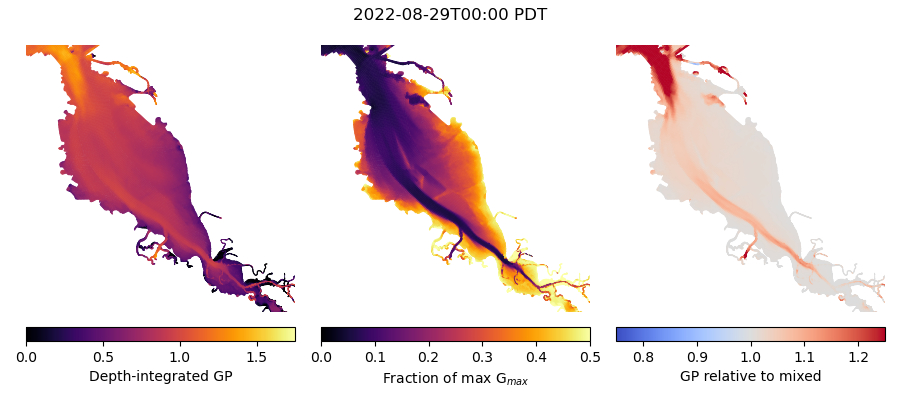

In [265]:
# Render the daily maps
fig_dir=os.path.join(model.run_dir,'growth_potential_daily_v00_figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
fig,axs = plt.subplots(1,3, figsize=(9,4.0))
for ax in axs:
    ax.axis('off')
    ax.set_adjustable('datalim')

def plot_cells(ax,values,label,**kw):
    if callable(values): values=values()
    coll = ds.grid.plot_cells(values=values,ax=ax,**kw)
    coll.set_lw(0.5)
    coll.set_edgecolor('face')
    plt.colorbar(coll, orientation='horizontal',ax=ax, label=label, pad=0.05, fraction=0.1)

snap=ds_daily.isel(time=0)

panels=[dict(ax=axs[0], values=lambda: snap['growth_int'], label='Depth-integrated GP', cmap='inferno', clim=[0,1.75]),
        dict(ax=axs[1],values=lambda: snap['growth_avg'],label='Fraction of max G$_{max}$', cmap='inferno', clim=[0,0.5]),
        dict(ax=axs[2],values=lambda: snap['growth_avg'] / snap['growth_mixed'], cmap='coolwarm', clim=[0.75,1.25],
             label='GP relative to mixed')
       ]

for panel in panels:
    plot_cells(**panel)
    
def time_str(): return str(snap['time'].values - np.timedelta64(7,'h'))[:16] + " PDT"

fig.suptitle(time_str())
fig.tight_layout()
for ax in axs:
    ax.axis((548258., 592431., 4146961., 4181391.))

for tidx in utils.progress(range(ds_daily.dims['time'])):
    snap=ds_daily.isel(time=tidx)
    for panel in panels:
        values = panel['values']
        if callable(values): values=values()
        panel['ax'].collections[0].set_array(values)
    fig.suptitle(time_str())
    plt.draw()
    fig.savefig(os.path.join(fig_dir,f"growth_potential_{tidx:04d}.png"),dpi=200)


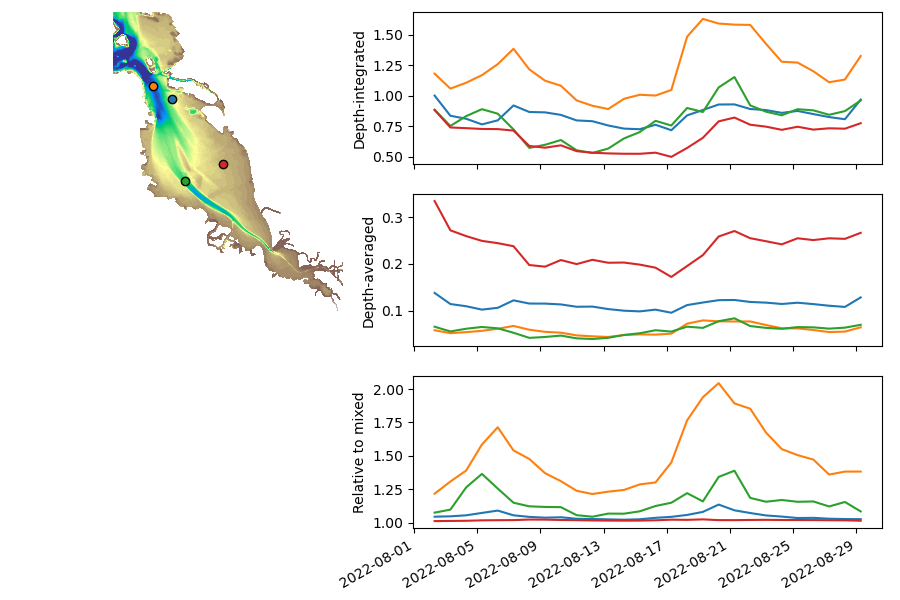

In [271]:
# Timeseries at several points
pnts=np.array( [
    [559600,4.1795e6], # just south of Alameda 
    [559600 - 3.5e3,4.1795e6 + 2.5e3], # epicenter 
    [562200,4.1637e6], # east of SFO
    [569400,4.1670e6], # Hayward-ish
])

gs=gridspec.GridSpec( 3,2, width_ratios=[0.33,0.67])

grid = ds.grid

fig=plt.figure(figsize=(9,6))

ax_grid=fig.add_subplot(gs[:2,0])
ax_grid.set_adjustable('datalim')
ax_grid.axis('off')
#grid.plot_edges(ax=ax_grid,lw=0.5,alpha=0.5,color='k')
grid.contourf_node_values(grid.nodes['NetNode_z'],np.linspace(-20,10,64), cmap='terrain',
                         extend='both') 
ax_grid.axis('equal')

ax_grid.axis((548258., 592431., 4146961., 4181391.))
markers = [ ax_grid.plot(pnt[0],pnt[1],marker='o',lw=0, mew=1, mec='k') for pnt in pnts]
colors=[m[0].get_color() for m in markers]

cells=[grid.select_cells_nearest(p) for p in pnts]


ax0=fig.add_subplot(gs[0,1])
ax1=fig.add_subplot(gs[1,1],sharex=ax0)
ax2=fig.add_subplot(gs[2,1],sharex=ax0)

for cell,color in zip(cells, colors):
    ax0.plot(ds_daily.time, ds_daily['growth_int'].isel(cell=cell))
    ax1.plot(ds_daily.time, ds_daily['growth_avg'].isel(cell=cell))
    ax2.plot(ds_daily.time, ds_daily['growth_avg'].isel(cell=cell) / ds_daily['growth_mixed'].isel(cell=cell))
ax0.set_ylabel('Depth-integrated')
ax1.set_ylabel('Depth-averaged')
ax2.set_ylabel('Relative to mixed')
for ax in [ax0,ax1]:
    plt.setp(ax.get_xticklabels(),visible=0)
fig.autofmt_xdate()
fig.subplots_adjust(right=0.98, top=0.98,bottom=0.12)


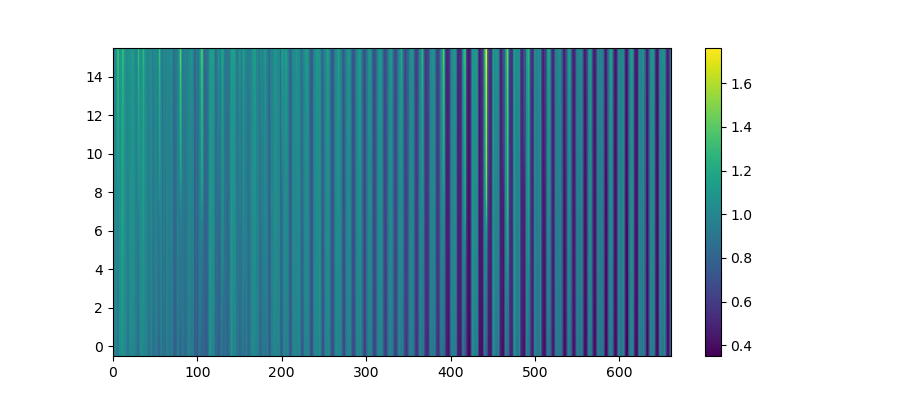

In [182]:
# What's going on the shoals to get worse than mixed conditions?
fig,ax=plt.subplots(figsize=(9,4))

shoal_conc = ds['conc0'].isel(nFlowElem=cells[0])

img=ax.imshow( shoal_conc.T, aspect='auto', origin='lower' )
plt.colorbar(img)

In [185]:
sigmas = utils.sigma_median(shoal_conc.values)

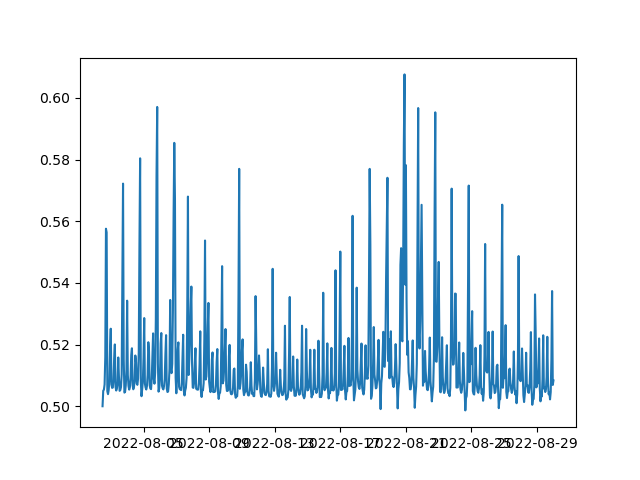

In [187]:
fig,ax=plt.subplots()
ax.plot( shoal_conc.time, sigmas)

In [70]:
# Getting a unified dataframe of relevant in-situ temperature observations
import insitu_temperature

insitu_df = insitu_temperature.all_stations()

INFO:noaa_coops:Cached   2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Cached   2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Cached   2022-09-01 00:00:00 -- 2022-10-01 00:00:00
INFO:noaa_coops:Cached   2022-10-01 00:00:00 -- 2022-11-01 00:00:00
INFO:noaa_coops:Cached   2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Cached   2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Cached   2022-09-01 00:00:00 -- 2022-10-01 00:00:00
INFO:noaa_coops:Cached   2022-10-01 00:00:00 -- 2022-11-01 00:00:00
INFO:noaa_coops:Cached   2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Cached   2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Cached   2022-09-01 00:00:00 -- 2022-10-01 00:00:00
INFO:noaa_coops:Cached   2022-10-01 00:00:00 -- 2022-11-01 00:00:00
INFO:noaa_coops:Cached   2022-07-01 00:00:00 -- 2022-08-01 00:00:00
INFO:noaa_coops:Cached   2022-08-01 00:00:00 -- 2022-09-01 00:00:00
INFO:noaa_coops:Cached   2022-09-01 00:00:00 -- 

In [84]:
stn_df = insitu_df.groupby('station').first().reset_index()

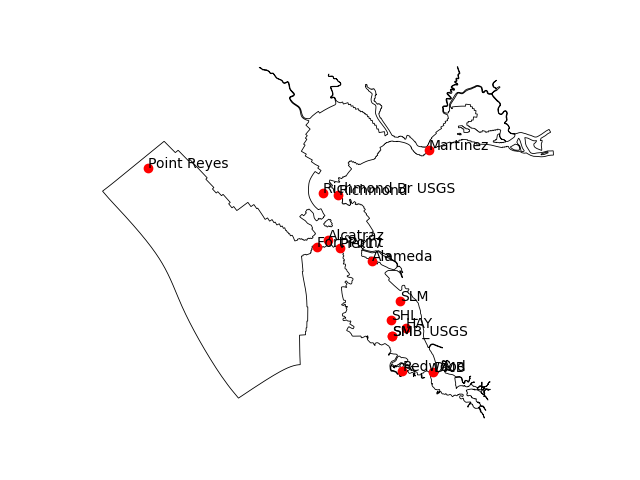

In [87]:
fig,ax=plt.subplots()
plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.6)
ax.axis('equal')
ax.axis('off')

ax.plot(stn_df.x, stn_df.y, 'ro')
for r in stn_df.itertuples():
    ax.text(r.x, r.y, r.station)
